In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from scipy.spatial import cKDTree
import warnings
import numpy as np
import pandas as pd
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

#### Import data exported from Pickcells

In [4]:
# Get nuclei features and working directory
proj_dir = os.getcwd()
proj_dir = os.path.dirname(proj_dir)
files = os.listdir(os.path.join(proj_dir, 'Data'))

#Get files containing the word tableset
raw_files = [f for f in files if 'tableset' in f]

#Import data
data = []
for idx, file in enumerate(raw_files):
    temp = pd.read_csv(os.path.join(proj_dir, 'Data', file), sep='\t')

    #break down the file name to get the embryo number
    file_parts = file.split('_')

    #Get the replicate number
    temp['embryo'] = int(file_parts[1][-1])
    data.append(temp)

data = pd.concat(data)

#reset index
data = data.reset_index(drop=True)

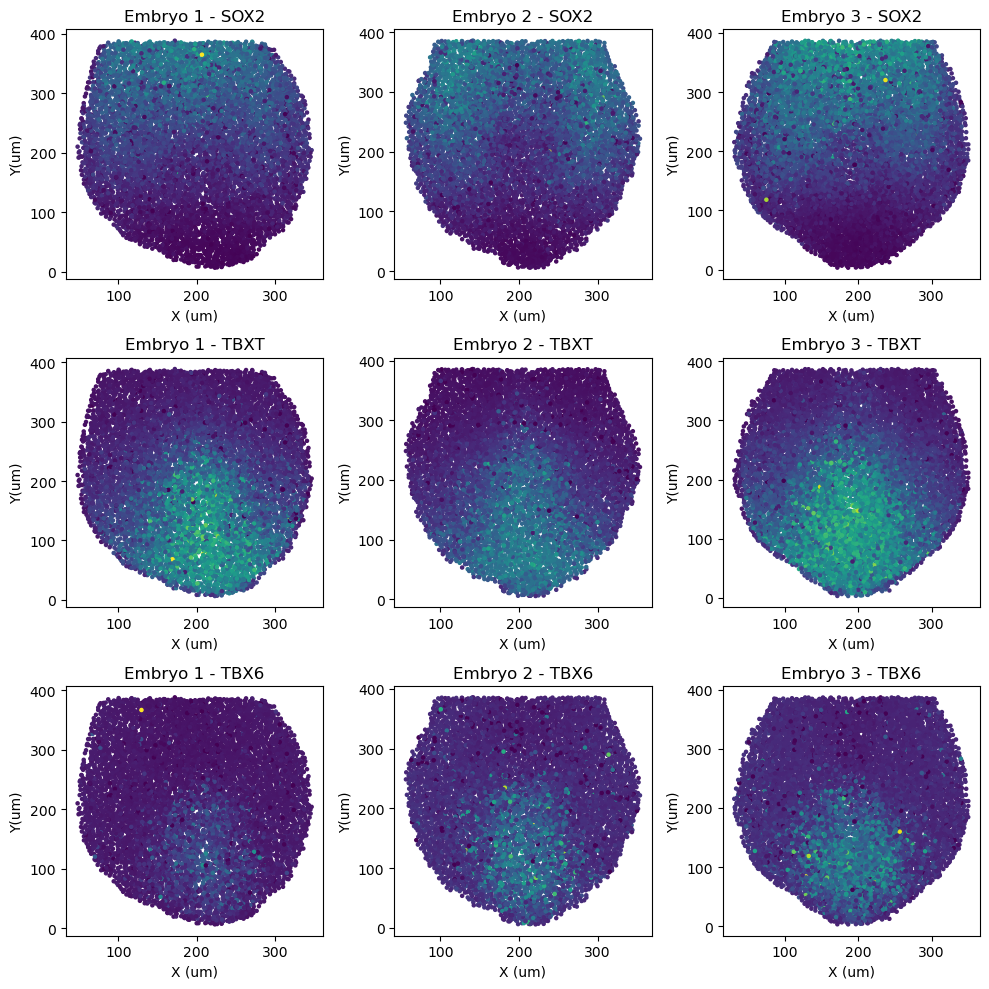

In [5]:
# Set channel names to genes
channels = ['SOX2', 'TBXT', 'TBX6']

data['SOX2'] = data['Mean Intensity 0']

odd_embryo_out = 3

data.loc[data['embryo'] == odd_embryo_out, 'TBXT'] = data.loc[data['embryo'] == odd_embryo_out, 'Mean Intensity 1']
data.loc[data['embryo'] != odd_embryo_out, 'TBXT'] = data.loc[data['embryo'] != odd_embryo_out, 'Mean Intensity 2']

data.loc[data['embryo'] == odd_embryo_out, 'TBX6'] = data.loc[data['embryo'] == odd_embryo_out, 'Mean Intensity 2']
data.loc[data['embryo'] != odd_embryo_out, 'TBXT'] = data.loc[data['embryo'] != odd_embryo_out, 'Mean Intensity 2']

data.loc[data['embryo'] != odd_embryo_out, 'TBX6'] = data.loc[data['embryo'] != odd_embryo_out, 'Mean Intensity 3']

#Display data per channel
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for idx, channel in enumerate(channels):
    for idx2, embryo in enumerate(data['embryo'].unique()):
        epi_nuclei = data[(data['embryo'] == embryo) & (data[channel] >= 0)]
        epi_nuclei = epi_nuclei[epi_nuclei['Epiblast'] >= 0]

        ax[idx, idx2].scatter(epi_nuclei['Centroid 0'], epi_nuclei['Centroid 1'], c = epi_nuclei[channel], s=5)

        ax[idx, idx2].set_title(f'Embryo {embryo} - {channel}')
        ax[idx, idx2].set_xlabel('X (um)')
        ax[idx, idx2].set_ylabel('Y(um)')

plt.tight_layout()
plt.show()



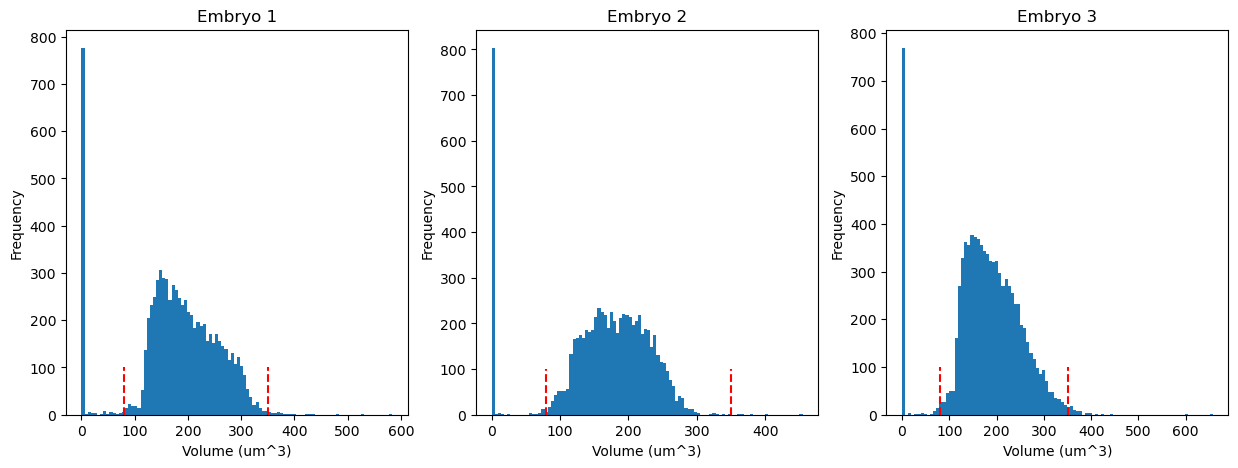

In [6]:
#Filter out small nuclei from segmentation/editing errors

#view size distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

min_vol = 80
max_vol = 350

for idx, embryo in enumerate(data['embryo'].unique()):
    epi_nuclei = data[(data['embryo'] == embryo) & (data['SOX2'] >= 0)]
    epi_nuclei = epi_nuclei[epi_nuclei['Epiblast'] >= 0]

    ax[idx].hist(epi_nuclei['volume'], bins=100)

    ax[idx].set_title(f'Embryo {embryo}')
    ax[idx].set_xlabel('Volume (um^3)')
    ax[idx].set_ylabel('Frequency')
    ax[idx].vlines(min_vol, 0, 100, color='r', linestyle='--')
    ax[idx].vlines(max_vol, 0, 100, color='r', linestyle='--')
#Filter out small nuclei and large nuclei
data = data[data['volume'] > min_vol]
data = data[data['volume'] < max_vol]

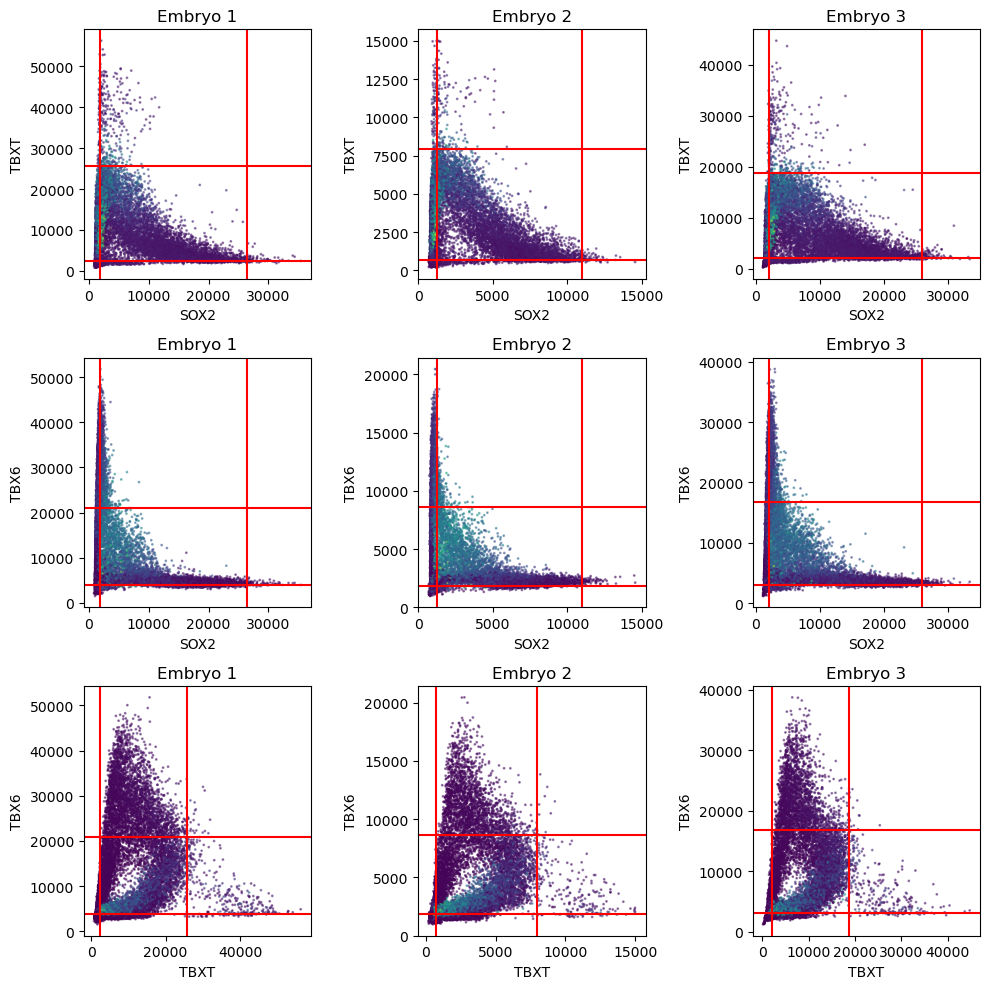

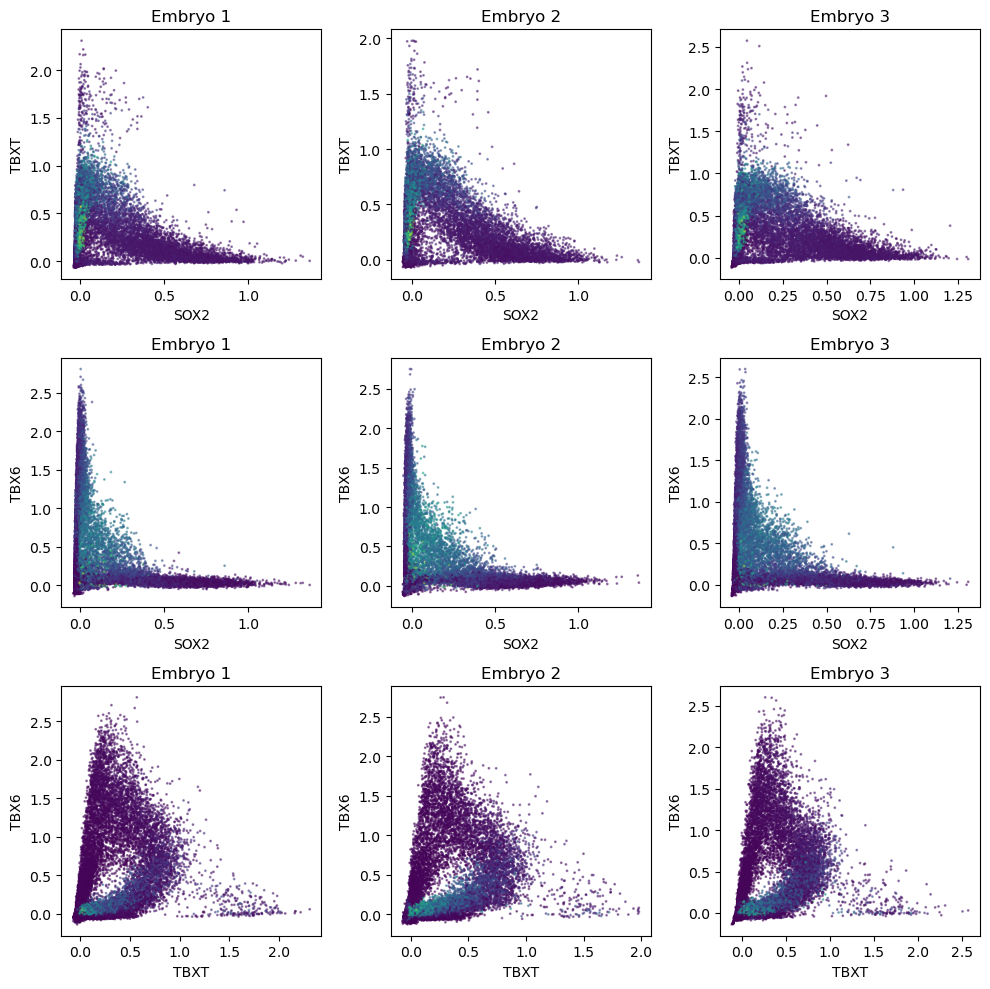

In [7]:
#Normalise data using percentiles

# Create dictionary to store thresholds
thresholds = {}

for idx, embryo in enumerate(data['embryo'].unique()):
    # Subset embryo and epiblast
    epi_nuclei = data[(data['embryo'] == embryo)]
    epi_nuclei = epi_nuclei[epi_nuclei['Epiblast'] >= 0]
    indices = epi_nuclei.index
    
    thresholds[idx] = {}
    
    for channel in channels:
        # Normalize data using percentiles (5th and 99th)
        lower = np.percentile(data.loc[indices, channel], 5)
        upper = np.percentile(data.loc[indices, channel], 99)
        
        data.loc[(data['embryo'] == embryo), (channel+'_norm')] = (data.loc[(data['embryo'] == embryo), channel] - lower) / (upper - lower)

        
        # Store thresholds for each embryo separately
        thresholds[idx][channel] = (lower, upper)

# Create plots
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for idx, embryo in enumerate(data['embryo'].unique()):
    embryo_data = data[data['embryo'] == embryo]

    ax[0, idx].scatter(embryo_data['SOX2'], embryo_data['TBXT'], c=embryo_data['TBX6'], s=1, alpha=0.5)
    ax[0, idx].axvline(thresholds[idx]['SOX2'][0], color='r')
    ax[0, idx].axvline(thresholds[idx]['SOX2'][1], color='r')
    ax[0, idx].axhline(thresholds[idx]['TBXT'][0], color='r')
    ax[0, idx].axhline(thresholds[idx]['TBXT'][1], color='r')
    ax[0, idx].set_title(f'Embryo {embryo}')
    ax[0, idx].set_xlabel('SOX2')
    ax[0, idx].set_ylabel('TBXT')


    ax[1, idx].scatter(embryo_data['SOX2'], embryo_data['TBX6'], c=embryo_data['TBXT'], s=1, alpha=0.5)
    ax[1, idx].axvline(thresholds[idx]['SOX2'][0], color='r')
    ax[1, idx].axvline(thresholds[idx]['SOX2'][1], color='r')
    ax[1, idx].axhline(thresholds[idx]['TBX6'][0], color='r')
    ax[1, idx].axhline(thresholds[idx]['TBX6'][1], color='r')
    ax[1, idx].set_title(f'Embryo {embryo}')
    ax[1, idx].set_xlabel('SOX2')
    ax[1, idx].set_ylabel('TBX6')



    ax[2, idx].scatter(embryo_data['TBXT'], embryo_data['TBX6'], c=embryo_data['SOX2'], s=1, alpha=0.5)
    ax[2, idx].axvline(thresholds[idx]['TBXT'][0], color='r')
    ax[2, idx].axvline(thresholds[idx]['TBXT'][1], color='r')
    ax[2, idx].axhline(thresholds[idx]['TBX6'][0], color='r')
    ax[2, idx].axhline(thresholds[idx]['TBX6'][1], color='r')
    ax[2, idx].set_title(f'Embryo {embryo}')
    ax[2, idx].set_xlabel('TBXT')
    ax[2, idx].set_ylabel('TBX6')

plt.tight_layout()
plt.show()

# Then plot the data on normlised scales

# Create plots
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for idx, embryo in enumerate(data['embryo'].unique()):
    embryo_data = data[data['embryo'] == embryo]

    ax[0, idx].scatter(embryo_data['SOX2_norm'], embryo_data['TBXT_norm'], c=embryo_data['TBX6_norm'], s=1, alpha=0.5)
    ax[0, idx].set_title(f'Embryo {embryo}')
    ax[0, idx].set_xlabel('SOX2')
    ax[0, idx].set_ylabel('TBXT')


    ax[1, idx].scatter(embryo_data['SOX2_norm'], embryo_data['TBX6_norm'], c=embryo_data['TBXT_norm'], s=1, alpha=0.5)
    ax[1, idx].set_title(f'Embryo {embryo}')
    ax[1, idx].set_xlabel('SOX2')
    ax[1, idx].set_ylabel('TBX6')

    ax[2, idx].scatter(embryo_data['TBXT_norm'], embryo_data['TBX6_norm'], c=embryo_data['SOX2_norm'], s=1, alpha=0.5)
    ax[2, idx].set_title(f'Embryo {embryo}')
    ax[2, idx].set_xlabel('TBXT')
    ax[2, idx].set_ylabel('TBX6')

plt.tight_layout()
plt.show()

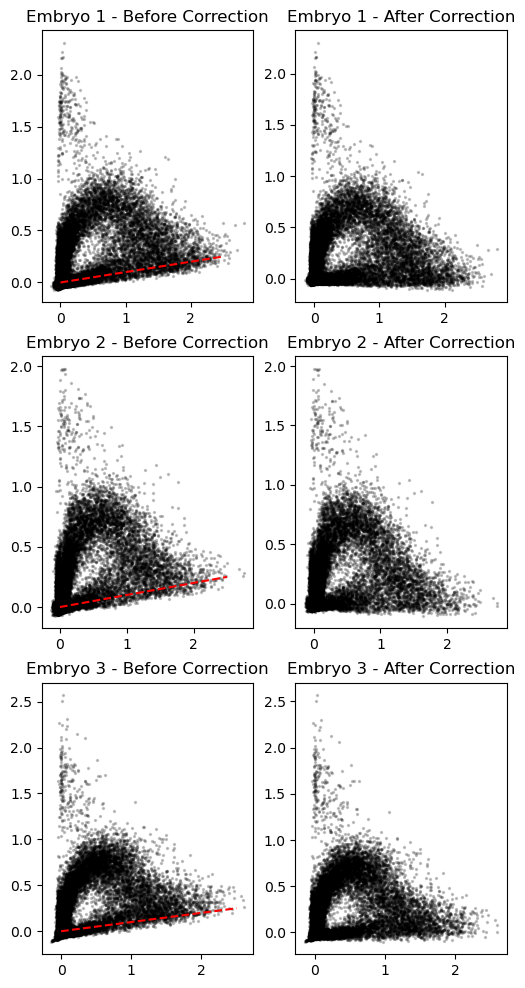

In [8]:
# Correct for bleedthrough from TBX6 to TBXT channels
fig, ax = plt.subplots(3, 2, figsize=(6, 12))

for idx, embryo in enumerate(data['embryo'].unique()):
    #plot the data before correction
    ax[idx, 0].scatter(data.loc[data['embryo'] == embryo, 'TBX6_norm'], data.loc[data['embryo'] == embryo, 'TBXT_norm'], c='black', s=2, alpha=0.2)
    ax[idx, 0].set_title(f'Embryo {embryo} - Before Correction')

    x = np.linspace(0, 2.5, 100)

    #Coefficient to scale TBX6 to correct TBXT (in normalised units)
    scaler = 0.1

    y = scaler * x

    #Plot before correction
    ax[idx, 0].plot(x, y, 'r--')
    data.loc[data['embryo'] == embryo, 'TBXT_norm'] -= scaler * data.loc[data['embryo'] == embryo, 'TBX6_norm']
    #plot the data after correction
    ax[idx, 1].scatter(data.loc[data['embryo'] == embryo, 'TBX6_norm'], data.loc[data['embryo'] == embryo, 'TBXT_norm'], c='black', s=2, alpha=0.2)
    ax[idx, 1].set_title(f'Embryo {embryo} - After Correction')
    

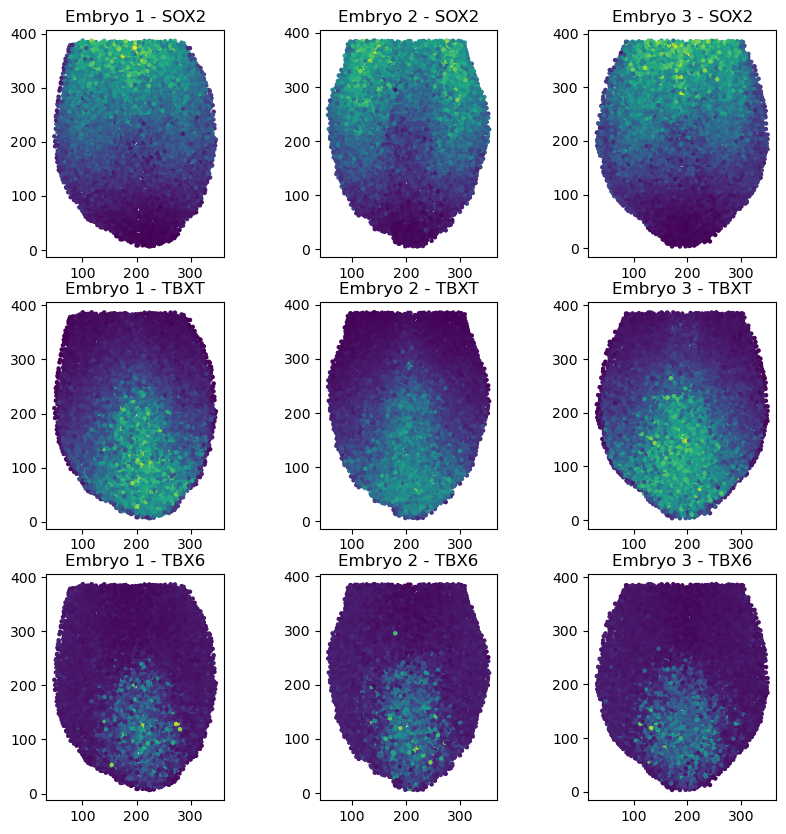

In [9]:
#Display corrected and normalised data in XY
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for idx, channel in enumerate(channels):
    for idx2, embryo in enumerate(data['embryo'].unique()):
        epi_nuclei = data[(data['embryo'] == embryo) & (data[channel] >= 0)]
        epi_nuclei = epi_nuclei[epi_nuclei['Epiblast'] >= 0]

        ax[idx, idx2].scatter(epi_nuclei['Centroid 0'], epi_nuclei['Centroid 1'], c = epi_nuclei[channel+'_norm'], s=5)

        ax[idx, idx2].set_title(f'Embryo {embryo} - {channel}')
        ax[idx, idx2].set_aspect('equal') 


### Calculate neighbour metrics

In [10]:
#Import edgelist data
edgelist_files = [f for f in files if 'edgelist' in f]

edgelist = []

for idx, file in enumerate(edgelist_files):
    temp = pd.read_csv(os.path.join(proj_dir, 'Data', file), sep='\t')

    #break down the file name to get the embryo number
    file_parts = file.split('_')

    #Get the replicate number
    temp['embryo'] = int(file_parts[1][-1])

    # Edge list is exported with each edge represented once, so for easy lookup we will duplicate the edges
    temp_2 = temp.copy()

    # Swap the information in the columns
    targets = temp['Database ID from Target']
    sources = temp['Database ID from Source']

    # Add the swapped information to the dataframe
    temp_2['Database ID from Target'] = sources
    temp_2['Database ID from Source'] = targets

    #Combine the two dataframes
    temp = pd.concat([temp, temp_2])

    # append to the list
    edgelist.append(temp)

edgelist = pd.concat(edgelist)

In [11]:
#precompute variables
for channel in channels:
    data[channel+'_Nbr_mean'] = np.nan
    data[channel+'_Nbr_std'] = np.nan
    data[channel+'_Niche_mean'] = np.nan
    data[channel+'_Niche_std'] = np.nan

data['Nbr_count'] = np.nan
data['Nbr_distance'] = np.nan

new_vars = [channel+'_Nbr_mean' for channel in channels] + [channel+'_Nbr_std' for channel in channels] + [channel+'_Niche_mean' for channel in channels] + [channel+'_Niche_std' for channel in channels] + ['Nbr_count', 'Nbr_distance']

# Loop through each embryo and calculate mean and standard deviation of each channel
for idx, embryo in enumerate((data['embryo'].unique())):
    print(f'Embryo {embryo}')
    temp_nuc_data = data[data['embryo'] == embryo]
    temp_edge_data = edgelist[edgelist['embryo'] == embryo]

    #eclude nuclei that are not in the epiblast and have nan as Epiblast
    epi_nuclei = temp_nuc_data[(temp_nuc_data['Epiblast'] >= 0)]

    for i in tqdm(range(len(epi_nuclei))):

        n_idx = epi_nuclei.index[i]
        # Get the neighbours of the nucleus
        sources = temp_edge_data[temp_edge_data['Database ID from Source'] == epi_nuclei.iloc[i]['Database ID']]
        niche_cells = epi_nuclei[epi_nuclei['Database ID'].isin(sources['Database ID from Target'])]

        #exclude the nucleus itself to only get neighbours
        nbrs = niche_cells[niche_cells['Database ID'] != epi_nuclei.iloc[i]['Database ID']]

        #Calculate mean and standard deviation of each channel for the neighbours and niche cells
        for channel in channels:
            epi_nuclei.loc[n_idx,channel+'_Nbr_mean'] = nbrs[channel].mean()
            epi_nuclei.loc[n_idx,channel+'_Nbr_std'] = nbrs[channel].std()

            epi_nuclei.loc[n_idx,channel+'_Niche_mean'] = niche_cells[channel].mean()
            epi_nuclei.loc[n_idx,channel+'_Niche_std'] = niche_cells[channel].std()

        #Calculate the number of neighbours
        epi_nuclei.loc[n_idx,'Nbr_count'] = len(nbrs)

        #Calculate the avergae distance of the neighbours
        epi_nuclei.loc[n_idx,'Nbr_distance'] = np.mean(sources['distance'])

    #insert back into data
    for new_var in new_vars:
        data.loc[epi_nuclei.index, new_var] = epi_nuclei[new_var]

#Calculate coefficients of variation
for channel in channels:
    data[channel+'_Niche_CV'] = data[channel+'_Niche_std'] / data[channel+'_Niche_mean']

Embryo 1


100%|██████████| 6751/6751 [00:29<00:00, 229.33it/s]


Embryo 2


100%|██████████| 6478/6478 [00:26<00:00, 240.02it/s]


Embryo 3


100%|██████████| 7973/7973 [00:37<00:00, 212.01it/s]


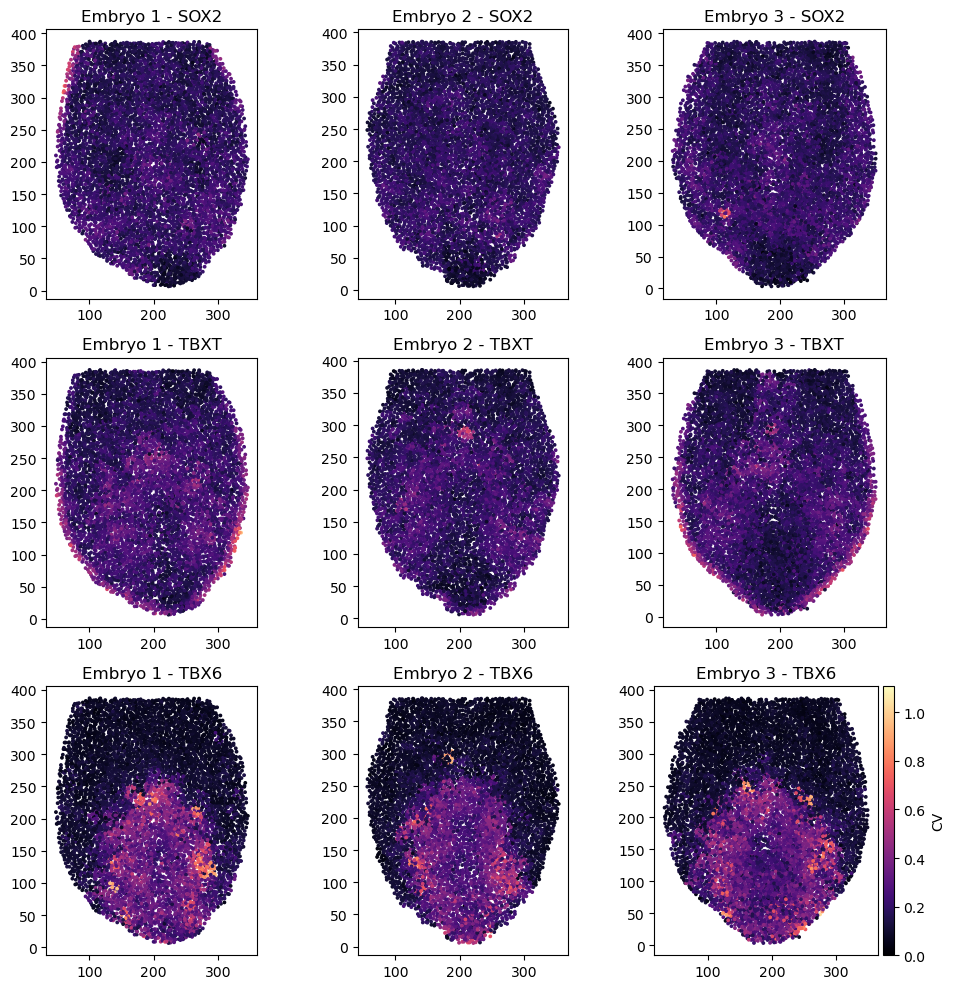

In [12]:
#Display corrected and normalised data in XY

max_cv  = np.nanmax((data['SOX2_Niche_CV'], data['TBXT_Niche_CV'], data['TBX6_Niche_CV']))

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for idx, channel in enumerate(channels):
    for idx2, embryo in enumerate(data['embryo'].unique()):
        epi_nuclei = data[(data['embryo'] == embryo) & (data[channel] >= 0)]
        epi_nuclei = epi_nuclei[epi_nuclei['Epiblast'] >= 0]

        ax[idx, idx2].scatter(epi_nuclei['Centroid 0'], epi_nuclei['Centroid 1'], c = epi_nuclei[channel+'_Niche_CV'], s=3,
                              cmap='magma', vmin=0, vmax=max_cv)

        ax[idx, idx2].set_title(f'Embryo {embryo} - {channel}')
        ax[idx, idx2].set_aspect('equal') 

#add colorbar
divider = make_axes_locatable(ax[2, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(ax[1, 2].collections[0], cax=cax, orientation='vertical')
cbar.set_label('CV')

plt.tight_layout()


In [13]:
#Save data progress
data.to_csv(os.path.join(proj_dir, 'Data', 'mouse_data_processing.csv'), index=False)